# IRI forecast as a trigger for drought in Burkina Faso
This notebook explores the option of using IRI's seasonal forecast as the indicator for a drought-related trigger in Burkina Faso. 
From the country team the proposed trigger is:
- Trigger #1 in March covering Apr-May-June. Threshold desired: 40%.
- Trigger #2 in July covering Aug-Sep-Oct. Threshold desired: 50%. 
- Targeted Admin1s: Boucle de Mounhoun, Centre Nord, Sahel, Nord.

This notebook explores if and when these triggers would be reached. Moreover, an exploration is done on how the raster data can be combined to come to one value for all 4 admin1s.

**TODO: look at distribution of normal and above average when high prob below avg**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
import geopandas as gpd
from shapely.geometry import mapping
import pandas as pd
import rioxarray
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from rasterstats import zonal_stats
from IPython.display import Markdown as md
from myst_nb import glue

from pathlib import Path
import sys
import os

path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
sys.path.append(path_mod)
from src.indicators.drought.config import Config

from src.indicators.drought.iri_rainfallforecast import get_iri_data

In [3]:
adm_sel=["Boucle du Mouhoun","Nord","Centre-Nord","Sahel"]
threshold_mar=40
threshold_jul=50

In [4]:
country="bfa"
config=Config()
parameters = config.parameters(country)
country_data_raw_dir = os.path.join(config.DATA_DIR,config.PUBLIC_DIR,config.RAW_DIR,country)
country_data_exploration_dir = os.path.join(config.DATA_DIR,config.PUBLIC_DIR,"exploration",country)

stats_reg_path=os.path.join(country_data_exploration_dir,f"{country}_iri_seasonal_forecast_stats_{''.join(adm_sel)}.csv")

adm1_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])
adm2_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin2_shp"])

In [5]:
iri_ds, iri_transform = get_iri_data(config, download=False)

these are the variables of the forecast data, where C indicates the tercile (below-average, normal, or above-average).  
F indicates the publication month, and L the leadtime

In [6]:
iri_ds

<xarray.Dataset>
Dimensions:      (C: 3, F: 51, L: 4, lat: 181, lon: 360)
Coordinates:
  * lat          (lat) float32 90.0 89.0 88.0 87.0 ... -87.0 -88.0 -89.0 -90.0
  * L            (L) float32 1.0 2.0 3.0 4.0
  * lon          (lon) float32 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * F            (F) object 2017-03-16 00:00:00 ... 2021-05-16 00:00:00
    spatial_ref  int64 ...
Dimensions without coordinates: C
Data variables:
    prob         (F, L, C, lat, lon) float64 ...
Attributes:
    grid_mapping:  spatial_ref

In [7]:
iri_ds.sel(L=1).prob

<xarray.DataArray 'prob' (F: 51, C: 3, lat: 181, lon: 360)>
[9969480 values with dtype=float64]
Coordinates:
  * lat          (lat) float32 90.0 89.0 88.0 87.0 ... -87.0 -88.0 -89.0 -90.0
    L            float32 1.0
  * lon          (lon) float32 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * F            (F) object 2017-03-16 00:00:00 ... 2021-05-16 00:00:00
    spatial_ref  int64 ...
Dimensions without coordinates: C
Attributes: (12/14)
    pointwidth:      1
    defaultvalue:    736.5
    units:           percent
    long_name:       Tercile Probability
    expires:         1622530800
    scale_min:       0.0
    ...              ...
    colormap:        [null 16777215 16777184 [16777184 44] 15658671 [15658671...
    colorscalename:  tercileclassesscale
    maxncolor:       254
    CS:              0
    CE:              100
    grid_mapping:    spatial_ref

In [8]:
gdf_adm1=gpd.read_file(adm1_bound_path)
iri_clip=iri_ds.rio.set_spatial_dims(x_dim="lon",y_dim="lat").rio.clip(gdf_adm1.geometry.apply(mapping), iri_ds.rio.crs, all_touched=True)

Below the raw forecast data of below-average rainfall with 1 month leadtime, published in March and July is shown.

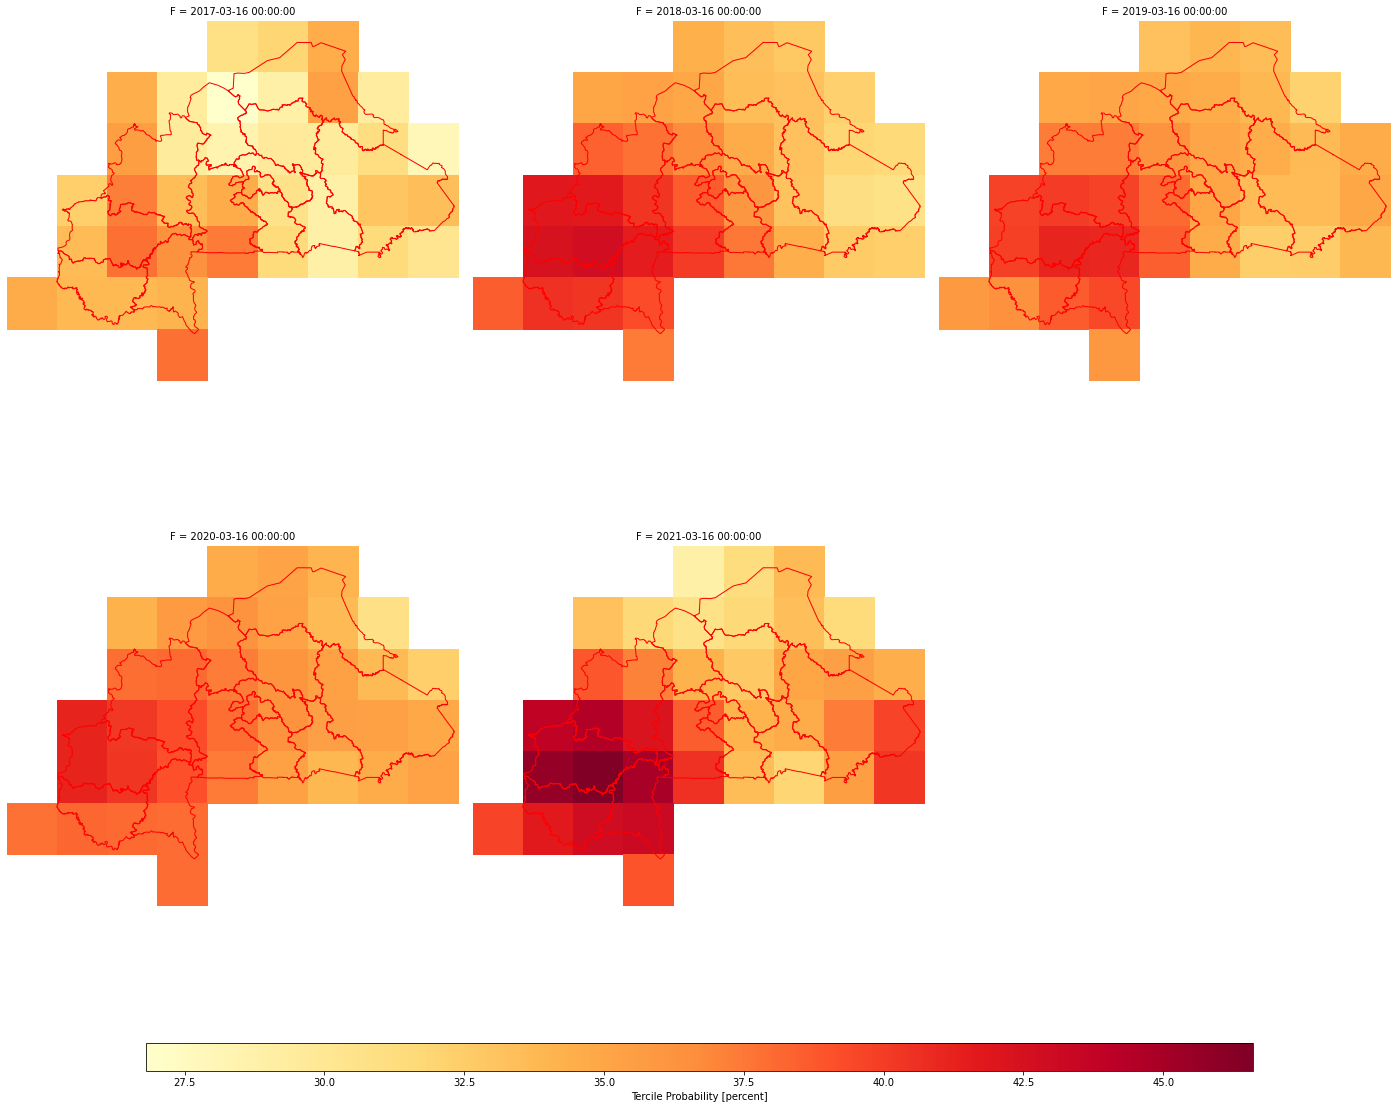

In [9]:
g=iri_clip.where(iri_clip.F.dt.month.isin([3]), drop=True).sel(L=1,C=0).prob.plot(
    col="F",
    col_wrap=3,
    cmap=mpl.cm.YlOrRd,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
    },
    figsize=(20,20)
)
df_bound = gpd.read_file(adm1_bound_path)
for ax in g.axes.flat:
    df_bound.boundary.plot(linewidth=1, ax=ax, color="red")
    ax.axis("off")
# fig.tight_layout()

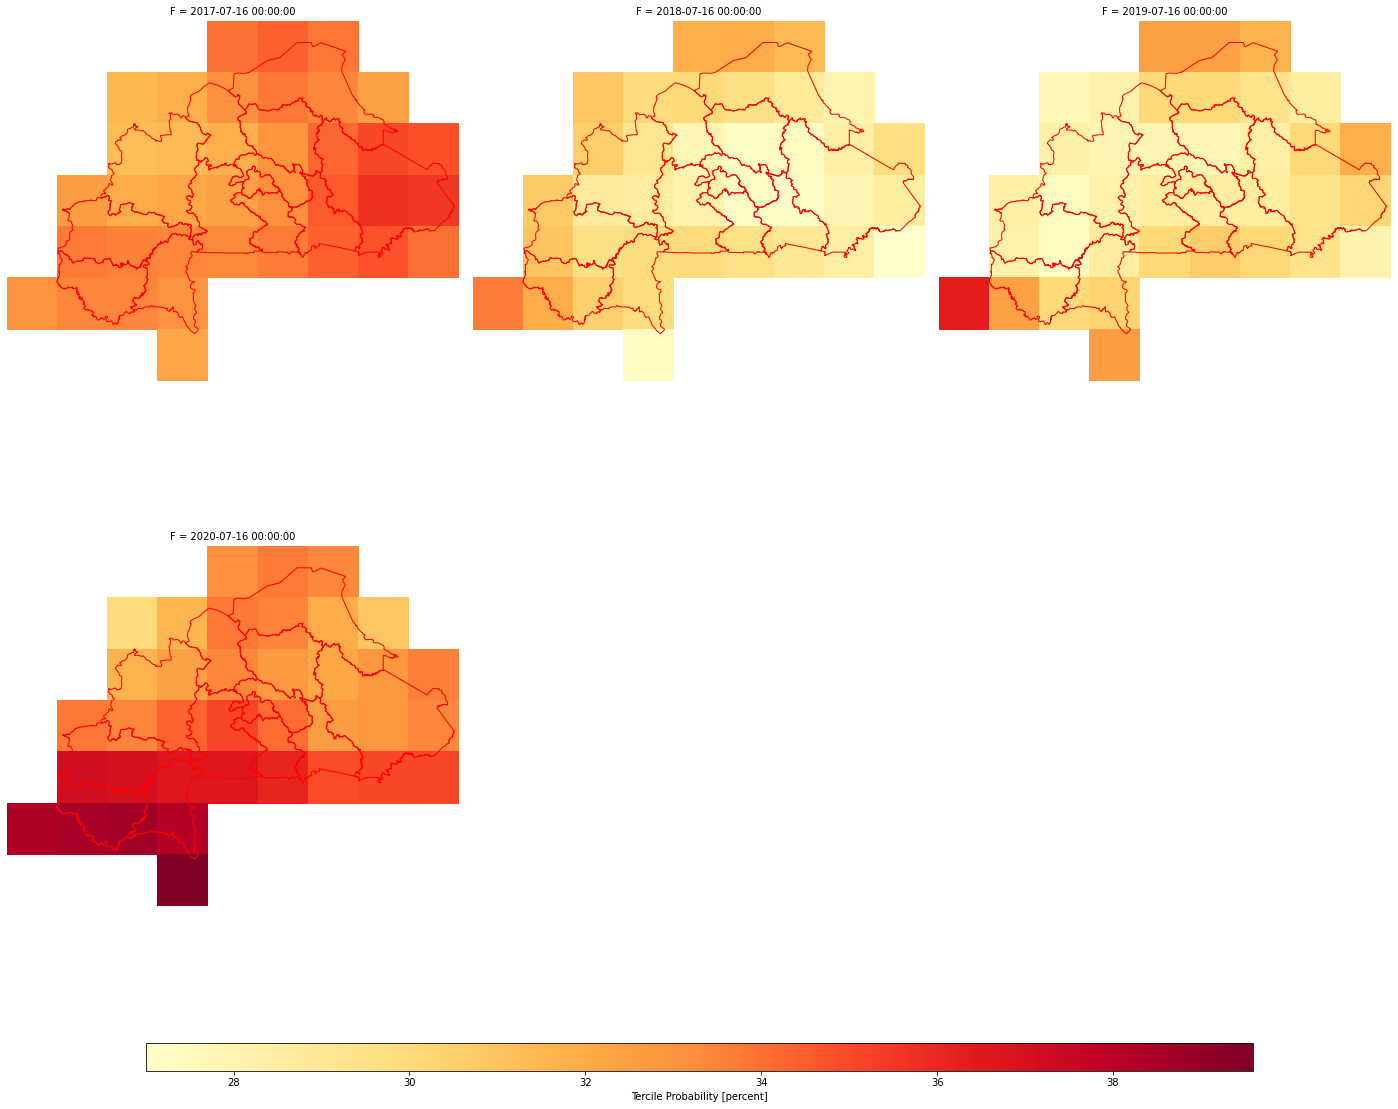

In [10]:
g=iri_clip.where(iri_clip.F.dt.month.isin([7]), drop=True).sel(L=1,C=0).prob.plot(
    col="F",
    col_wrap=3,
    cmap=mpl.cm.YlOrRd,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
    },
    figsize=(20,20)
)
df_bound = gpd.read_file(adm1_bound_path)
for ax in g.axes.flat:
    df_bound.boundary.plot(linewidth=1, ax=ax, color="red")
    ax.axis("off")

In [11]:
def interpolate_ds(ds,transform,upscale_factor):
    # Interpolated data
    new_lon = np.linspace(ds.lon[0], ds.lon[-1], ds.dims["lon"] * upscale_factor)
    new_lat = np.linspace(ds.lat[0], ds.lat[-1], ds.dims["lat"] * upscale_factor)

    #choose nearest as interpolation method to assure no new values are introduced but instead old values are divided into smaller raster cells
    dsi = ds.interp(lat=new_lat, lon=new_lon,method="nearest")
#     transform_interp=transform*transform.scale(len(ds.lon)/len(dsi.lon),len(ds.lat)/len(dsi.lat))
    
    return dsi#, transform_interp

In [12]:
iri_clip_interp=interpolate_ds(iri_clip,iri_clip.rio.transform(),8)

In [13]:
iri_clip_interp

<xarray.Dataset>
Dimensions:      (C: 3, F: 51, L: 4, lat: 56, lon: 72)
Coordinates:
  * L            (L) float32 1.0 2.0 3.0 4.0
  * F            (F) object 2017-03-16 00:00:00 ... 2021-05-16 00:00:00
    spatial_ref  int64 0
  * lat          (lat) float64 15.0 14.89 14.78 14.67 ... 9.327 9.218 9.109 9.0
  * lon          (lon) float64 -6.0 -5.887 -5.775 -5.662 ... 1.775 1.887 2.0
Dimensions without coordinates: C
Data variables:
    prob         (F, L, C, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    grid_mapping:  spatial_ref

In [14]:
iri_clip_interp.rio.transform(recalc=True)

Affine(0.11267605633802817, 0.0, -6.056338028169014,
       0.0, -0.10909090909090909, 15.054545454545455)

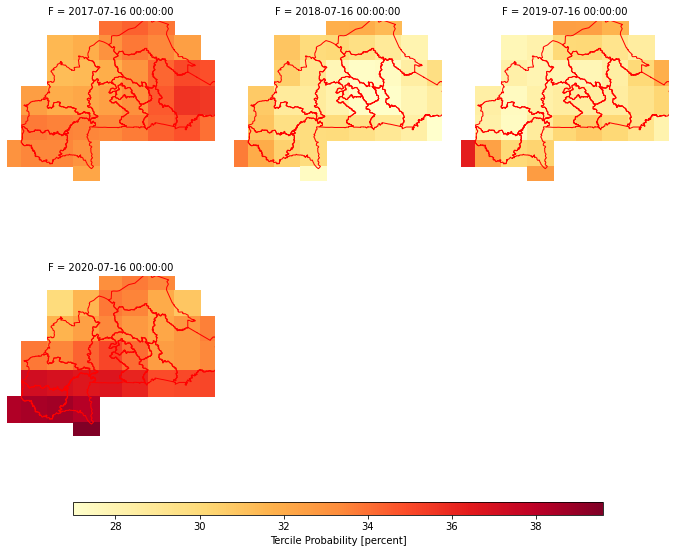

In [15]:
#check that interpolated values look fine
g=iri_clip_interp.where(iri_clip_interp.F.dt.month.isin([7]), drop=True).sel(L=1,C=0).prob.plot(
    col="F",
    col_wrap=3,
    cmap=mpl.cm.YlOrRd, 
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
    },
    figsize=(10,10)
)
df_bound = gpd.read_file(adm1_bound_path)
for ax in g.axes.flat:
    df_bound.boundary.plot(linewidth=1, ax=ax, color="red")
    ax.axis("off")

we select the region of interest, shown below

In [16]:
gdf_reg=gdf_adm1[gdf_adm1.ADM1_FR.isin(adm_sel)]

(-6.056338028169014, 2.056338028169014, 8.945454545454545, 15.054545454545455)

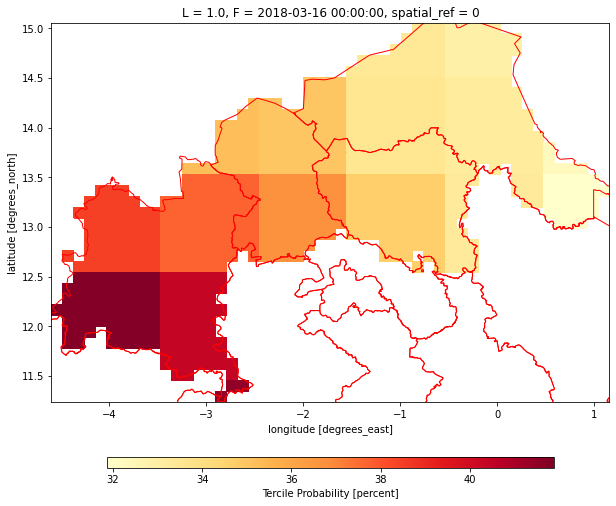

In [17]:
#testing if correct area
iri_interp_reg=iri_clip_interp.rio.set_spatial_dims(x_dim="lon",y_dim="lat").rio.clip(gdf_reg.geometry.apply(mapping), iri_clip_interp.rio.crs, all_touched=False)
g=iri_interp_reg.sel(L=1,C=0,F="2018-03").prob.plot(
    cmap=mpl.cm.YlOrRd, 
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
    },
    figsize=(10,10)
)
df_bound = gpd.read_file(adm1_bound_path)
df_bound.boundary.plot(linewidth=1, ax=g.axes, color="red")
ax.axis("off")

In [18]:
def compute_zonal_stats_xarray(raster,shapefile,lon_coord="lon",lat_coord="lat",var_name="prob"):
    raster_clip=raster.rio.set_spatial_dims(x_dim=lon_coord,y_dim=lat_coord).rio.clip(shapefile.geometry.apply(mapping),raster.rio.crs,all_touched=False)
    grid_mean = raster_clip.mean(dim=[lon_coord,lat_coord]).rename({var_name: "mean_cell"})
    grid_min = raster_clip.min(dim=[lon_coord,lat_coord]).rename({var_name: "min_cell"})
    grid_max = raster_clip.max(dim=[lon_coord,lat_coord]).rename({var_name: "max_cell"})
    grid_std = raster_clip.std(dim=[lon_coord,lat_coord]).rename({var_name: "std_cell"})
    grid_quant90 = raster_clip.quantile(0.9,dim=[lon_coord,lat_coord]).rename({var_name: "10quant_cell"})
    grid_percth40 = raster_clip.where(raster_clip.prob >=40).count(dim=[lon_coord,lat_coord])/raster_clip.count(dim=[lon_coord,lat_coord])*100
    grid_percth40=grid_percth40.rename({var_name: "40percth_cell"})
    zonal_stats_xr = xr.merge([grid_mean, grid_min, grid_max, grid_std,grid_quant90,grid_percth40]).drop("spatial_ref")
    zonal_stats_df=zonal_stats_xr.to_dataframe()
    zonal_stats_df=zonal_stats_df.reset_index()
    return zonal_stats_df

In [19]:
stats_region=compute_zonal_stats_xarray(iri_clip_interp,gdf_reg)
stats_region["F"]=pd.to_datetime(stats_region["F"].apply(lambda x: x.strftime('%Y-%m-%d')))
stats_region["month"]=stats_region.F.dt.month

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [20]:
# stats_region.to_csv(stats_reg_path,index=False)

In [21]:
stats_region_bavg_l1=stats_region[(stats_region.C==0)&(stats_region.L==1)]

And compute the statistics over this region, see a subset below

In [22]:
stats_region[(stats_region.C==0)&(stats_region.L==1)&(stats_region.F.dt.month==3)]

,C,F,L,mean_cell,min_cell,max_cell,std_cell,10quant_cell,quantile,40percth_cell,month
0,0,2017-03-16,1.0,31.495157,26.800935,37.261748,3.252510,35.567945,0.9,0.000000,3
48,0,2018-03-16,1.0,35.963292,31.873917,41.878787,2.903000,40.363758,0.9,16.275862,3
96,0,2019-03-16,1.0,35.965496,32.200421,41.015097,2.129139,39.771293,0.9,8.551724,3
144,0,2020-03-16,1.0,36.544649,30.768471,41.184953,2.025928,39.318485,0.9,8.275862,3
192,0,2021-03-16,1.0,35.403506,30.697005,44.935194,4.227613,42.255976,0.9,16.275862,3


Below the distribution of probability values is shown per month. \
This only includes the values for the below-average tercile, with a leadtime of 1. \
It should be noted that since we only have data from Mar 2017, these distributions contain maximum 5 values. \
From the distribution, it can be seen that a probability of 50% has never been reached since Mar 2017.

In [23]:
stats_mar=stats_region_bavg_l1.loc[stats_region_bavg_l1.F.dt.month==3]
stats_jul=stats_region_bavg_l1.loc[stats_region_bavg_l1.F.dt.month==7]

In [24]:
def comb_list_string(str_list):
    if len(str_list)>0:
        return " in "+", ".join(str_list)
    else:
        return ""

max_prob_mar=stats_region_bavg_l1.loc[stats_region_bavg_l1.F.dt.month==3,'max_cell'].max()
num_trig_mar=len(stats_mar.loc[stats_mar['max_cell']>=threshold_mar])
year_trig_mar=comb_list_string([str(y) for y in stats_mar.loc[stats_mar['max_cell']>=threshold_mar].F.dt.year.unique()])

num_trig_jul=len(stats_jul.loc[stats_jul['max_cell']>=threshold_jul])
year_trig_jul=comb_list_string([str(y) for y in stats_jul.loc[stats_jul['max_cell']>=threshold_jul].F.dt.year.unique()])
max_prob_jul=stats_region_bavg_l1.loc[stats_region_bavg_l1.F.dt.month==7,'max_cell'].max()

In [25]:
glue("max_prob_mar", max_prob_mar)
glue("max_prob_jul", max_prob_jul)
glue("num_trig_mar", num_trig_mar)
glue("num_trig_jul", num_trig_jul)
glue("year_trig_mar", year_trig_mar)
glue("year_trig_jul", year_trig_jul)
glue("threshold_mar", threshold_mar)
glue("threshold_jul", threshold_jul)

44.93519369687384

36.66180243665207

4

0

' in 2018, 2019, 2020, 2021'

''

40

50

More specifically we are interested in March and July. 
The maximum values across all cells for the March forecasts has been {glue:text}`max_prob_mar:.2f`%, and for the July forecasts {glue:text}`max_prob_jul:.2f`% 
This would mean that if we would take the max cell as aggregation method, the threshold of {glue:text}`threshold_mar` for March would have been reached {glue:text}`num_trig_mar` times {glue:text}`year_trig_mar`. 
For July the threshold of {glue:text}`threshold_jul` would have been reached {glue:text}`num_trig_jul` times{glue:text}`year_trig_jul`."

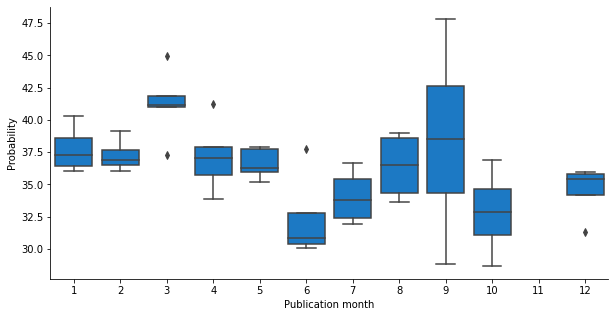

In [26]:
#plot distribution for forecasts with C=0 (=below average) and L=1, for all months
fig,ax=plt.subplots(figsize=(10,5))
g=sns.boxplot(data=stats_region_bavg_l1,x="month",y="max_cell",ax=ax,color="#007CE0")
ax.set_ylabel("Probability")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Publication month");

In [27]:
stats_country=compute_zonal_stats_xarray(iri_clip_interp,gdf_adm1)
stats_country["F"]=pd.to_datetime(stats_country["F"].apply(lambda x: x.strftime('%Y-%m-%d')))
stats_country["month"]=stats_country.F.dt.month
glue("max_prob_mar_country",stats_country.loc[(stats_country.C==0)&(stats_country.L==1)&(stats_country.F.dt.month==3),'max_cell'].max())
glue("max_prob_jul_country",stats_country.loc[(stats_country.C==0)&(stats_country.L==1)&(stats_country.F.dt.month==3),'max_cell'].max())

46.59822141306648

46.59822141306648

To check if these below 50% and below 40% probabilities depend on the part of the country, we also compute the maximum values in the whole country across all years. While the values can be slightly higher in other regions, the 50% threshold is never reached. 
We can see that the maximum probabilities in other regions are a bit higher, while still never reaching the 50% threshold.

The maximum value for the March forecast in the whole country was {glue:text}`max_prob_mar_country:.2f`%. \
For July this was {glue:text}`max_prob_jul_country:.2f`%"

In [28]:
perc_for_40th=stats_country.loc[(stats_country.C==0)&(stats_country.L==1),'max_cell'].ge(40).value_counts(True)[True]*100
glue("perc_for_maxcell_40th",perc_for_40th)

25.49019607843137

#TODO: might want to look at at least 1% instead of at least 1 cell  
#TODO: remove nan cells

Across all months, {glue:text}`perc_for_maxcell_40th:.2f`% of the forecasts with 1 month leadtime had a >=40% probability of below average rainfall in at least one cell across the **whole** country

Text(0.5, 0, 'Publication month')

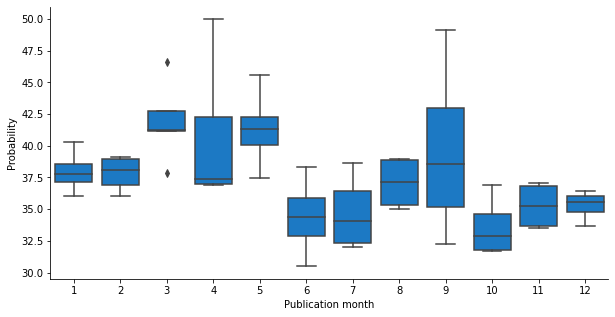

In [29]:
#plot distribution for forecasts with C=0 (=below average) and L=1, for all months
fig,ax=plt.subplots(figsize=(10,5))
g=sns.boxplot(data=stats_country[(stats_country.C==0)&(stats_country.L==1)],x="month",y="max_cell",ax=ax,color="#007CE0")
ax.set_ylabel("Probability")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Publication month")

In [30]:
max_prob_mar=stats_region_bavg_l1.loc[stats_region_bavg_l1.F.dt.month==3,'max_cell'].max()
num_trig_mar_mean=len(stats_mar.loc[stats_mar['mean_cell']>=threshold_mar])
year_trig_mar_mean=comb_list_string([str(y) for y in stats_mar.loc[stats_mar['mean_cell']>=threshold_mar].F.dt.year.unique()])
num_trig_mar_perc10=len(stats_mar.loc[stats_mar['10quant_cell']>=threshold_mar])
year_trig_mar_perc10=comb_list_string([str(y) for y in stats_mar.loc[stats_mar['10quant_cell']>=threshold_mar].F.dt.year.unique()])
max_perc40_mar=stats_mar["40percth_cell"].max()
glue("num_trig_mar_mean", num_trig_mar_mean)
glue("year_trig_mar_mean", year_trig_mar_mean)
glue("num_trig_mar_perc10", num_trig_mar_perc10)
glue("year_trig_mar_perc10", year_trig_mar_perc10)
glue("max_perc40_mar", max_perc40_mar)

0

''

2

' in 2018, 2021'

16.275862068965516

While taking the max cell is the most extreme method of aggregation, we have many other possiblities. Such as looking at the mean, or at a percentage of cells. 
For the July forecast we wouldn't trigger with any method of aggregation, since we already didn't trigger with the max methodology. 

For March, when using the mean method aggregation, the trigger would have been met {glue:text}`num_trig_mar_mean` times{glue:text}`year_trig_mar_mean`.

Below the distribution of the percentage of the area with >=40% probability is shown. From here it can be seen that the maximum percentage is {glue:text}`max_perc40_mar:.2f`%.
We look at the distribution of the percentage of the area with >=40% probability of below avg rainfall for the admins of interest, across all forecasts with a leadtime of 1. 
When requiring 10% of cells to be above 40% this would be met {glue:text}`num_trig_mar_perc10:.2f` times{glue:text}`year_trig_mar_perc10:.2f`.

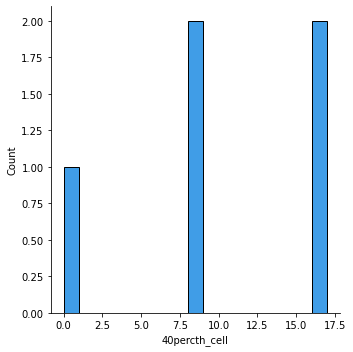

In [31]:
#plot distribution for forecasts with C=0 (=below average) and L=1, for all months
g=sns.displot(stats_region_bavg_l1.loc[stats_region_bavg_l1["month"]==3,"40percth_cell"],color="#007CE0",binwidth=1)

In [32]:
#TODO: add to show that 40% barely happens

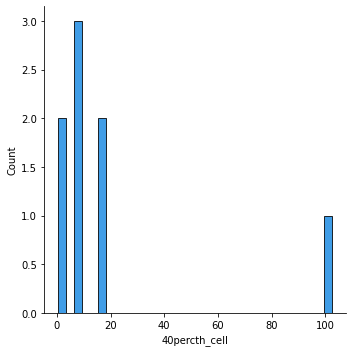

In [33]:
#plot distribution for forecasts with C=0 (=below average) and L=1, for all months
g=sns.displot(stats_region_bavg_l1.loc[stats_region_bavg_l1["40percth_cell"]>0,"40percth_cell"],color="#007CE0",binwidth=3)

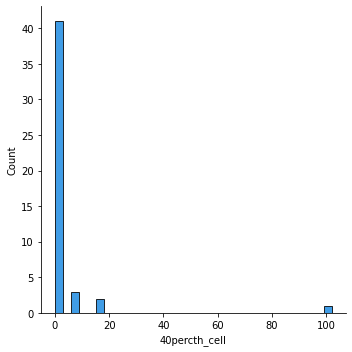

In [34]:
#plot distribution for forecasts with C=0 (=below average) and L=1, for all months
g=sns.displot(stats_region_bavg_l1.loc[:,"40percth_cell"],color="#007CE0",binwidth=3)

In [35]:
#TODO: remove nan cells
#perc for with at least 1% >40% prob
sum(np.where(stats_region_bavg_l1["40percth_cell"]>=1,1,0))/len(stats_region_bavg_l1)*100
#at least 10%
sum(np.where(stats_region_bavg_l1["40percth_cell"]>=10,1,0))/len(stats_region_bavg_l1)*100
# np.nanpercentile(stats_region_bavg_l1["40percth_cell"], 90)

5.88235294117647

Text(0.5, 0, 'Publication month')

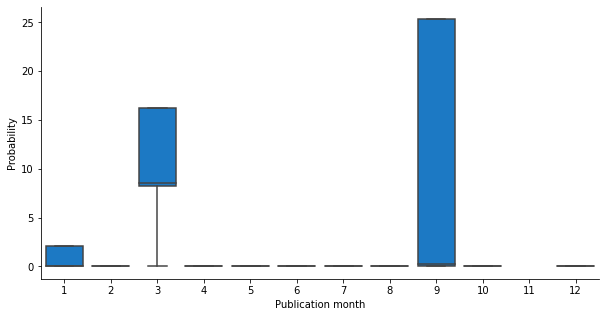

In [36]:
#plot distribution for forecasts with C=0 (=below average) and L=1, for all months
fig,ax=plt.subplots(figsize=(10,5))
g=sns.boxplot(data=stats_region_bavg_l1,x="month",y="40percth_cell",ax=ax,color="#007CE0",showfliers=False)
ax.set_ylabel("Probability")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Publication month")

Text(0.5, 0, 'Publication month')

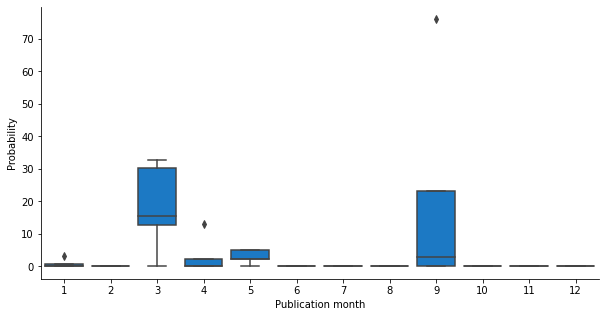

In [37]:
#plot distribution for forecasts with C=0 (=below average) and L=1, for all months
fig,ax=plt.subplots(figsize=(10,5))
g=sns.boxplot(data=stats_country[(stats_country.C==0)&(stats_country.L==1)],x="month",y="40percth_cell",ax=ax,color="#007CE0")
ax.set_ylabel("Probability")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Publication month")

## Test different method of computing stats

In [38]:
def compute_zonal_stats(ds, raster_transform, adm_path,adm_col,percentile_list=np.arange(10,91,10)):
    # compute statistics on level in adm_path for all dates in ds
    df_list = []
    for date in ds.F.values:
        df = gpd.read_file(adm_path)[[adm_col,"geometry"]]
        ds_date = ds.sel(F=date)
        
        df[["mean_cell", "max_cell", "min_cell"]] = pd.DataFrame(
            zonal_stats(vectors=df, raster=ds_date.values, affine=raster_transform, nodata=np.nan))[
            ["mean", "max", "min"]]

        df[[f"percentile_{str(p)}" for p in percentile_list]] = pd.DataFrame(
            zonal_stats(vectors=df, raster=ds_date.values, affine=raster_transform, nodata=np.nan,
                        stats=" ".join([f"percentile_{str(p)}" for p in percentile_list])))[
            [f"percentile_{str(p)}" for p in percentile_list]]

        df["date"] = pd.to_datetime(date.strftime("%Y-%m-%d"))

        df_list.append(df)
    df_hist = pd.concat(df_list)
    #drop the geometry column, else csv becomes huge
    df_hist=df_hist.drop("geometry",axis=1)

    return df_hist

In [39]:
#this was the old method
iri_date=iri_clip_interp.sel(L=1,C=0,F="2018-03").prob
#add recalc=True such that transform is recalculated after the interpolation, instead of using the cached version!!
#if using transform_interp, i.e. the output of interpolate_ds, the results are slightly different. Probability due to a bit less precision in the transform
df_stats=compute_zonal_stats(iri_date,iri_clip_interp.rio.transform(recalc=True),adm1_bound_path,parameters["shp_adm1c"])
df_stats["date"]=pd.to_datetime(df_stats["date"])
df_stats[(df_stats.ADM1_FR.isin(adm_sel))&(df_stats.date.dt.month==3)]

,ADM1_FR,mean_cell,max_cell,min_cell,percentile_10,percentile_20,percentile_30,percentile_40,percentile_50,percentile_60,percentile_70,percentile_80,percentile_90,date
0,Boucle du Mouhoun,39.565648,41.878787,35.271130,37.735180,37.735180,38.453984,38.453984,40.363758,40.363758,40.363758,41.792957,41.792957,2018-03-16
4,Centre-Nord,34.396130,36.708924,33.223838,33.296230,33.585452,33.585452,34.723427,34.723427,34.723427,34.723427,34.723427,34.991765,2018-03-16
9,Nord,36.038983,37.735180,34.991765,34.991765,34.991765,35.271130,35.271130,36.708924,36.708924,36.708924,36.708924,37.529929,2018-03-16
11,Sahel,33.304035,34.991765,31.873917,32.275978,32.897940,33.223838,33.223838,33.223838,33.434319,33.585452,33.585452,33.585452,2018-03-16


In [40]:
#geocube is the suggested method by rioxarray
#results are slightly different than current method, and don't understand why
#with geocube you can directly compute different regions, but think you have to compute separability per other variable (L,F,C)
import geopandas
import numpy
import rioxarray
import xarray as xr
from geocube.api.core import make_geocube
gdf_adm1=gpd.read_file(adm1_bound_path)
#make categorical value
gdf_adm1["mukey"] = range(len(gdf_adm1))
gdf_adm1["mukey"]=gdf_adm1["mukey"].astype(int)

mask = make_geocube(
    gdf_adm1,
    measurements=["mukey"],
    like=iri_ds,
    fill=0,
)

out_grid = make_geocube(
    vector_data=gdf_adm1,
    measurements=["mukey"],
    like=iri_clip_interp.sel(L=1,C=0,F="2018-03").prob, # ensure the data are on the same grid
    fill=np.nan
)
out_grid["iri"] = iri_clip_interp.rename({'lon': 'x','lat': 'y'}).sel(L=1,C=0,F="2018-03").prob

grouped_elevation = out_grid.drop("spatial_ref").groupby(out_grid.mukey)
grid_mean = grouped_elevation.mean().rename({"iri": "iri_mean"})
grid_min = grouped_elevation.min().rename({"iri": "iri_min"})
grid_max = grouped_elevation.max().rename({"iri": "iri_max"})
grid_std = grouped_elevation.std().rename({"iri": "iri_std"})
zonal_stats_xr = xr.merge([grid_mean, grid_min, grid_max, grid_std])
stats_region=zonal_stats_xr.to_dataframe()
stats_region.reset_index().merge(gdf_adm1,on="mukey")[["ADM1_FR","iri_mean"]]

,ADM1_FR,iri_mean
0,Boucle du Mouhoun,39.582661
1,Cascades,41.347100
2,Centre,37.033878
3,Centre-Est,34.245415
4,Centre-Nord,34.458694
5,Centre-Ouest,39.382242
6,Centre-Sud,37.001245
7,Est,31.884276
8,Hauts-Bassins,42.180311
9,Nord,36.005561


```{toctree}
:hidden:
:titlesonly:


bfa_seas_bavg_precip_corr_obsfor
```